## Attention is all you need

Personal implementation in tensorflow keras of  https://arxiv.org/abs/1706.03762

http://jalammar.github.io/illustrated-transformer/  and http://nlp.seas.harvard.edu/2018/04/03/attention.html were heavily used as an inspiration source.

WORK IN PROGRESS ....

In [0]:
import tensorflow as tf
import numpy as np
import math
import logging

import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

!tensorboard --logdir ./logs --port 6006 --debugger_port 6064

In [0]:
tfe = tf.contrib.eager

tf.enable_eager_execution()

from tensorflow.python import debug as tf_debug


### Simple problem to solve
learn to copy a input vector of digits

In [0]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import SGD, RMSprop


In [0]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input
#from tensorflow.keras.optimizers import SGD


In [0]:
import tensorflow.keras.backend as K

In [0]:
K.set_session(
    tf_debug.TensorBoardDebugWrapperSession(tf.Session(), "91001b0abf93:6064"))


## Start from the outside to the inside

Start with the global structure of model -> then implement each block and layers

embedding_size=25
hidden_size = 20
input = Input(shape=(max_len,vocab_size))
#print(input.shape)
embedded = layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len)(input)
#print(embedded.shape)
self_att = SelfAttentionLayer(hidden_size)(embedded)

y_pred = layers.Dense(1, activation='softmax')(self_att[0])

class TransformerModel(Model):
    def __init__(self, embedding_size, hidden_size,vocab_size, max_len):
        super(TransformerModel, self).__init__(name='')
        self.embedding_size=embedding_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.embedded = layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len)
        self.self_att = SelfAttentionLayer(self.hidden_size)
        
    def call(self, input, training=False):
        print(input.shape)
        x = self.embedded(input)
        q,k,v = self.self_att(x)
        return q,k,v

embedding_size=25
hidden_size = 20
vocab_size=10  #vocabulary size
max_len = 5
transformer = TransformerModel(embedding_size, hidden_size, vocab_size, max_len)


In [0]:
def data_gen(vocab_size, max_len, batch_size, batch_nb):
    "Generate random data for a src-tgt copy task."
    for i in range(batch_nb):
        src = np.random.randint(0, vocab_size, size=(batch_size, max_len))
        src_cat = to_categorical(src)
        tgt = src
        tgt_cat = to_categorical(tgt)
        yield (src, src_cat, tgt, tgt_cat )

batch_size=2
batch_nb = 1
vocab_size = 10

for src,src_cat,tgt,tgt_cat in data_gen(vocab_size, max_len, batch_size, batch_nb):
    #transformer(src)
    src

src,src_cat

model = Model(input, y_pred)
model.summary()
optim = tf.train.GradientDescentOptimizer(learning_rate=0.01)
model.compile(optimizer=optim,loss='categorical_crossentropy')

In [0]:
class SelfAttentionLayer(layers.Layer):
    
    def __init__(self, hidden_size,attention_head_nb=8):
        super(SelfAttentionLayer, self).__init__()
        self.hidden_size=hidden_size
        self.attention_head_nb = attention_head_nb
    
    def build(self, input_shape ):
        #print("input_shape:",input_shape, input_shape[-1].value)
        self.WQ = self.add_weight("WQ", 
                                    shape=[input_shape[-1].value, 
                                    self.hidden_size])
        self.WK = self.add_weight("WK", 
                                    shape=[input_shape[-1].value, 
                                    self.hidden_size])
        self.WV = self.add_weight("WV", 
                                    shape=[input_shape[-1].value, 
                                    self.hidden_size])
        

        self.WQs = []
        self.WKs = []
        self.WVs = []
        
        self.W0 = self.add_weight("W0",shape=[self.hidden_size*self.attention_head_nb,self.hidden_size])
        
        for i in range(self.attention_head_nb):
            self.WQs.append( self.add_weight("WQ-"+str(i), 
                                    shape=[input_shape[-1].value, 
                                    self.hidden_size]))
            self.WKs.append( self.add_weight("WK-"+str(i), 
                        shape=[input_shape[-1].value, 
                        self.hidden_size]))
                
            self.WVs.append( self.add_weight("WV-"+str(i), 
                    shape=[input_shape[-1].value, 
                    self.hidden_size]))
        self.built = True
        
    def self_attend(self, input, WQ, WK, WV):
        tf.logging.debug("Shape input: {0}".format(input.shape))
        # use K.dot instead of tf.matmul because tf.matmul don't support dot product of a batch (3d) by a matrix (2d)
        
        query = K.dot(input, WQ) 
        key = K.dot(input, WK)
        value = K.dot(input, WV)
        
        tf.logging.debug("Shapes, query: {0}, WQ: {1}, key: {2}, WK: {3}, value: {4}, WV: {5}".format(query.shape,
                                                                                                       WQ.shape,
                                                                                                       key.shape,
                                                                                                       WK.shape,
                                                                                                       value,
                                                                                                       WV.shape))
        
        tf.logging.debug("Transposed key shape: {0}".format(tf.transpose(key,perm=[0,2,1]).shape))
        score = tf.matmul(query,tf.transpose(key,perm=[0,2,1]))
        tf.logging.debug("score shape: {0}".format(score.shape))
        divided_score = tf.divide(score,8)
        tf.logging.debug("score divided by 8: {0}".format(divided_score.shape))
        softmax = tf.nn.softmax(divided_score)
        tf.logging.debug("softmax: {0}".format(softmax.shape))
        z = tf.matmul(softmax,value)
        tf.logging.debug("z: {0}".format(z.shape))
        #assert z.shape[1]== self.hidden_size, "z shape second dim should be equal to hidden size"
        assert np.array_equal(z.shape[1:],value.shape[1:]),"z shape and value shape should be equals:"
        return z
        
    
    def call(self, input):
        zs = []
        for i in range(self.attention_head_nb):
            wq = self.WQs[i]
            wk = self.WKs[i]
            wv = self.WVs[i]
            z = self.self_attend(input,wq,wk,wv)
            zs.append(z)
        concat_z = K.concatenate(zs)
        
        assert concat_z.shape[2]==self.hidden_size*self.attention_head_nb, "concantenated z should be hidden_size* attention_head_nb long"
        tf.logging.debug("Concatenated Z shape: {0}".format(concat_z.shape))
        
        layer_output = K.dot(concat_z, self.W0)
        assert layer_output.shape[2] == self.hidden_size, "layer output second dim should be equal to hidden size"
        tf.logging.debug("Layer output shape: {0}".format(layer_output.shape))
        return layer_output

    

In [9]:
embedding_size=25
hidden_size = 20
max_len = 15
vocab_size=10  

tf.test.gpu_device_name()

''

In [0]:
class PositionalEncodingLayer(layers.Layer):
    
    def __init__(self, hidden_size,dropout_proba,max_len=5000):
        super(PositionalEncodingLayer, self).__init__()
        self.hidden_size=hidden_size
        self.dropout = 1-dropout_proba
        self.max_len=max_len
    
    def build(self,input_shape):
        1+1
    
    def call(self,input):
        tf.logging.debug("Input: {0}".format(input.shape))
        #pe = tf.Variable(lambda:tf.zeros([self.max_len, self.hidden_size],dtype=tf.float32))
        #pe = tf.Variable(np.zeros((self.max_len, self.hidden_size)),dtype=tf.float32)
        pe = K.variable(np.zeros((self.max_len, self.hidden_size)),dtype=tf.float32)
        tf.logging.debug("pe: {0}".format(pe.shape))
        position = tf.expand_dims(tf.range(0,self.max_len, 1, dtype=tf.float32),1)
        tf.logging.debug("position: {0}".format(position.shape))
        div_term = tf.exp(
                        tf.range(0,self.hidden_size,2,dtype=tf.float32) * -(tf.log(tf.constant(10000.0)) / self.hidden_size)
        )
        tf.logging.debug("div_term: {0}".format(div_term.shape))
        pos_div_term = position * div_term
        tf.logging.debug("pos mult by div_term: {0}".format(pos_div_term.shape))
        tf.assign(pe[:,0::2],tf.sin(pos_div_term))
        tf.assign(pe[:,1::2],tf.cos(pos_div_term))
        #tf.logging.debug("updated pe: ", str(pe.shape))
        
        pe = tf.expand_dims(pe,0)
        tf.logging.debug("updated pe: {0} ".format(pe.shape))
        
        # It should have the same shape as input
        returned_pe = pe[:, :input.shape[1]]
        input_and_pe = input + returned_pe
        tf.logging.debug("pos encoding (pe) + input embeddings : {0} ".format(input_and_pe.shape))
        input_and_pe_drop = tf.nn.dropout(input_and_pe, self.dropout)
        
        return input_and_pe_drop




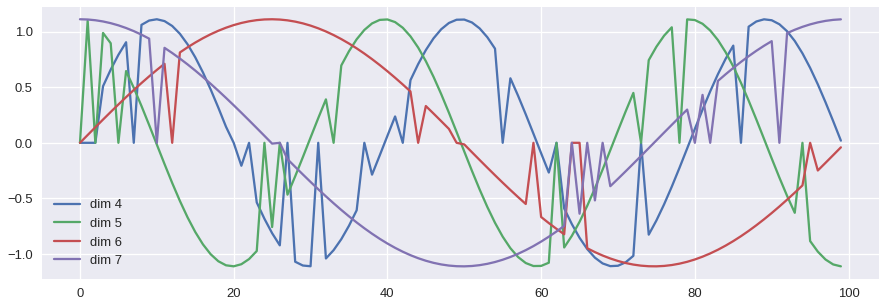

In [14]:
tf.logging.set_verbosity(tf.logging.ERROR)


pos_enc_seq = tf.keras.Sequential([PositionalEncodingLayer(20,0.1)])
x = tf.zeros((1,100,20),dtype=tf.float32)
y = pos_enc_seq(x)
tf.logging.debug('y: {0}'.format(y.shape))
plt.figure(figsize=(15, 5))
plt.plot(np.arange(100), y[0, :, 4:8])
plt.legend(["dim %d"%p for p in [4,5,6,7]])

In [11]:
pos_enc = np.array([
    [pos / np.power(10000, 2 * (j // 2) / embedding_size) for j in range(embedding_size)] 
        if pos != 0 else np.zeros(embedding_size) 
            for pos in range(max_len)
            ])
pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
pos_enc.shape

(15, 25)

In [12]:

cbs =[ tf.keras.callbacks.TensorBoard(log_dir='./logs')]
tf.logging.set_verbosity(tf.logging.DEBUG)

input = Input(shape=(max_len,vocab_size))
#print(input.shape)
embedded = layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len)(input)
self_att = SelfAttentionLayer(hidden_size)(embedded)

DEBUG:tensorflow:Shape input: (?, 15, 25)
DEBUG:tensorflow:Shapes, query: (?, 15, 20), WQ: (25, 20), key: (?, 15, 20), WK: (25, 20), value: Tensor("self_attention_layer/Reshape_8:0", shape=(?, 15, 20), dtype=float32), WV: (25, 20)
DEBUG:tensorflow:Transposed key shape: (?, 20, 15)
DEBUG:tensorflow:score shape: (?, 15, 15)
DEBUG:tensorflow:score divided by 8: (?, 15, 15)
DEBUG:tensorflow:softmax: (?, 15, 15)
DEBUG:tensorflow:z: (?, 15, 20)
DEBUG:tensorflow:Shape input: (?, 15, 25)
DEBUG:tensorflow:Shapes, query: (?, 15, 20), WQ: (25, 20), key: (?, 15, 20), WK: (25, 20), value: Tensor("self_attention_layer/Reshape_17:0", shape=(?, 15, 20), dtype=float32), WV: (25, 20)
DEBUG:tensorflow:Transposed key shape: (?, 20, 15)
DEBUG:tensorflow:score shape: (?, 15, 15)
DEBUG:tensorflow:score divided by 8: (?, 15, 15)
DEBUG:tensorflow:softmax: (?, 15, 15)
DEBUG:tensorflow:z: (?, 15, 20)
DEBUG:tensorflow:Shape input: (?, 15, 25)
DEBUG:tensorflow:Shapes, query: (?, 15, 20), WQ: (25, 20), key: (?, 15,

It should return

- input: max_len * embedding_size
- query shape: max_len * hidden_size
- weight query shape : embedding_size * hidden_size

In [0]:
batch_size=4
batch_nb = 1

model = Model(input,self_att)
model.compile(tf.train.GradientDescentOptimizer(learning_rate=0.01), 'mse')
for src,src_cat,tgt,tgt_cat in data_gen(vocab_size, max_len, batch_size, batch_nb):
    #transformer(src)
    src

    output_array = model.predict(src)

#src,src_cat
#output_array.shape


DEBUG:tensorflow:Shape input: (4, 15, 25)
DEBUG:tensorflow:Shapes, query: (4, 15, 20), WQ: (25, 20), key: (4, 15, 20), WK: (25, 20), value: [[[ 4.44511976e-03  1.51079465e-02  4.06683125e-02 ... -1.85186341e-02
   -3.18874121e-02 -7.23998994e-03]
  [-1.78733859e-02  4.50834483e-02 -6.87789023e-02 ...  4.64544911e-03
    7.96483457e-03  2.81966757e-04]
  [ 1.97431748e-03 -8.39156844e-03  2.63411757e-02 ...  4.88273278e-02
    6.11499175e-02 -8.58121738e-03]
  ...
  [-7.23005692e-03  2.11854465e-03  7.25130364e-02 ...  6.15358911e-03
   -8.18605423e-02  1.77434832e-02]
  [-7.23005692e-03  2.11854465e-03  7.25130364e-02 ...  6.15358911e-03
   -8.18605423e-02  1.77434832e-02]
  [ 1.59777887e-02  2.51839124e-02  7.12427683e-03 ...  2.67755985e-02
    2.97291391e-03  3.69649455e-02]]

 [[-1.78733859e-02  4.50834483e-02 -6.87789023e-02 ...  4.64544911e-03
    7.96483457e-03  2.81966757e-04]
  [ 4.44511976e-03  1.51079465e-02  4.06683125e-02 ... -1.85186341e-02
   -3.18874121e-02 -7.23998994e-